# Ablation study on the Infinite deck environment

In [1]:
import gym
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gaussian_smoothing(x: np.ndarray, window: int = 100000) -> np.ndarray:
    """smooth the curve using gaussian smoothing"""
    kernel = np.exp(-np.linspace(-1, 1, window)**2)
    kernel /= kernel.sum()
    return np.convolve(x, kernel, mode='valid')

import torch
from torchaudio.functional import convolve as torch_convolve

def gaussian_smoothing_gpu(x: np.ndarray, window: int = 10_000) -> np.ndarray:
    """smooth the curve using gaussian smoothing"""
    x = torch.from_numpy(x).cuda()
    kernel = torch.exp(-torch.linspace(-1, 1, window)**2).cuda()
    kernel /= kernel.sum()
    x = x.float()
    kernel = kernel.float()
    return torch_convolve(x, kernel, mode='valid').cpu().numpy()

def plot_training_rewards(rewards: np.ndarray):
    """plot the training rewards"""
    running_average = gaussian_smoothing_gpu(rewards)
    plt.plot(running_average)
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Running average reward")
    plt.show()

In [3]:
from src.envs import Blackjack

In [4]:
def multi_test(agents, n_test_episodes):
    results = []
    for agent in agents:
        env = Blackjack(seed=666)
        rewards = [play_episode(env, agent) for i in range(n_test_episodes)]
        rewards = np.array(rewards)
        n_wins = np.sum(rewards == 1)
        n_draws = np.sum(rewards == 0)
        results.append((n_wins / n_test_episodes, n_draws / n_test_episodes))
    return results        

def multi_plot(rewards_list, results, title, factor, values):
    plt.figure(figsize=(30, 8), dpi=80)
    plt.gca().set_xticks([])  # Remove x-axis tick marks
    plt.gca().set_xticklabels([])  # Remove x-axis labels
    plt.gca().spines['bottom'].set_visible(False)  # Hide x-axis line
    plt.gca().spines['top'].set_visible(False)  # Hide x-axis line
    for k, (rewards, result, value) in enumerate(zip(rewards_list, results, values)):
        plt.subplot(1, len(rewards_list), k + 1, sharey=plt.gca())
        running_average = gaussian_smoothing_gpu(rewards)
        plt.plot(running_average)
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title(f"{factor} = {value}, Win Rate: {result[0]:.4f}, Draw Rate: {result[1]:.4f}")
    plt.suptitle(title)
    plt.show()

    plt.figure(figsize=(30, 8), dpi=80)
    plt.plot(values, [result[0] for result in results], label="Win Rate")
    plt.plot(values, [result[1] for result in results], label="Draw Rate")
    plt.xlabel(f"{factor}")
    plt.ylabel("Rate")
    plt.title("Win and Draw Rate")
    plt.legend()
    plt.show()

In [5]:
device = torch.device("cpu")
n_test_episodes = 1_000_000

### Encoding DQN

In [6]:
from src.agents.dqn import DQN
from src.utils.general import get_input_dim_encoding, state_to_tensor_encoding
from src.utils.data_struct import Transition, DQNParameters
from src.explorations import EpsilonGreedy
from src.utils.buffer import ReplayBuffer
from src.networks import MLP
import torch

def main_encoding(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    rewards = np.zeros(n_episodes)
    for k in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_tensor_encoding(state, env.observation_space)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_tensor_encoding(next_state, env.observation_space)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)
        rewards[k] = reward.item()

    print(f"Training took {time.time() - start:.2f} seconds")
    return rewards

def train_encoding(n_episodes, eps, decay, gamma, freq_target_update, batch_size, hidden_dim, depth, buffer_capacity, lr, weight_decay):
    env = Blackjack(seed=42)
    exploration = EpsilonGreedy(epsilon=eps, decay=decay, seed=42)
    dqn_parameters = DQNParameters(batch_size=batch_size, gamma=gamma, freq_target_update=freq_target_update, device=device)

    network = MLP(input_dim=get_input_dim_encoding(env.observation_space), output_dim=env.action_space.n, hidden_dim=hidden_dim, depth=depth)
    target_network = MLP(input_dim=get_input_dim_encoding(env.observation_space), output_dim=env.action_space.n, hidden_dim=hidden_dim, depth=depth)
    target_network.load_state_dict(network.state_dict())

    network = network.to(device)
    target_network = target_network.to(device)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(network.parameters(), lr=lr, weight_decay=weight_decay)
    buffer = ReplayBuffer(capacity=buffer_capacity)

    agent = DQN(q_network=network, target_network=target_network, params=dqn_parameters, exploration=exploration, criterion=criterion, optimizer=optimizer, replay_buffer=buffer)

    rewards = main_encoding(env, agent, n_episodes)
    return rewards, agent

def play_episode(env, agent):
    state = env.reset()
    state = state_to_tensor_encoding(state, env.observation_space)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        next_state = state_to_tensor_encoding(next_state, env.observation_space)
        state = next_state
    return reward


100%|██████████| 100000/100000 [02:05<00:00, 798.94it/s]


Training took 125.17 seconds


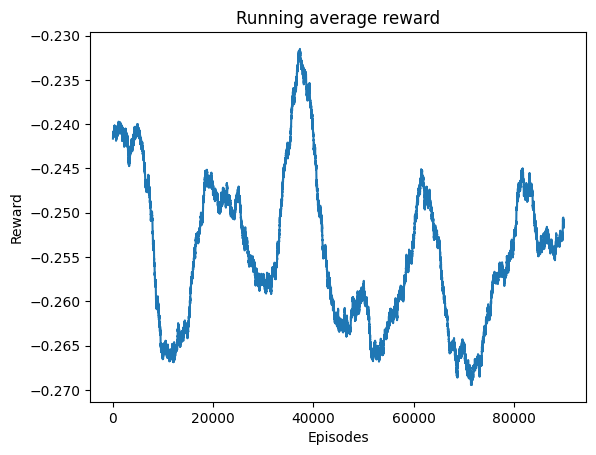

In [10]:
eps = 0.1
decay = 1
gamma = 0.9
freq_target_update = 100
batch_size = 32
hidden_dim = 64
depth = 1
buffer_capacity = 100_000
lr = 1e-3
weight_decay = 1e-4
n_episodes = 100_000

rewards, agent = train_encoding(n_episodes, eps, decay, gamma, freq_target_update, batch_size, hidden_dim, depth, buffer_capacity, lr, weight_decay)
plot_training_rewards(rewards)

In [11]:
env = Blackjack(seed=666)
rewards = [play_episode(env, agent) for i in range(n_test_episodes)]
rewards = np.array(rewards)
n_wins = np.sum(rewards == 1)
n_draws = np.sum(rewards == 0)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

Win rate: 0.3681
Draw rate: 0.0537


In [7]:
from src.utils.general import state_to_tensor_embedding
from src.networks import MLPEmbedding

def main_embedding(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    rewards = np.zeros(n_episodes)
    for k in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_tensor_embedding(state, env.observation_space, env.max_number_of_cards)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_tensor_embedding(next_state, env.observation_space, env.max_number_of_cards)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)
        rewards[k] = reward.item()

    print(f"Training took {time.time() - start:.2f} seconds")
    return rewards

def train_embedding(n_episodes, eps, decay, gamma, freq_target_update, batch_size, hidden_dim, depth, buffer_capacity, lr, weight_decay):
    env = Blackjack(seed=42)
    input_range = env.observation_space["dealer"].high.item() - env.observation_space["dealer"].low.item() + 1

    exploration = EpsilonGreedy(epsilon=eps, decay=decay, seed=42)
    dqn_parameters = DQNParameters(batch_size=batch_size, gamma=gamma, freq_target_update=freq_target_update, device=device)

    network = MLPEmbedding(input_dim=1, output_dim=env.action_space.n, hidden_dim=hidden_dim, depth=depth, input_range=input_range)
    target_network = MLPEmbedding(input_dim=1, output_dim=env.action_space.n, hidden_dim=hidden_dim, depth=depth, input_range=input_range)
    target_network.load_state_dict(network.state_dict())

    network = network.to(device)
    target_network = target_network.to(device)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(network.parameters(), lr=lr, weight_decay=weight_decay)
    buffer = ReplayBuffer(capacity=buffer_capacity)

    agent = DQN(q_network=network, target_network=target_network, params=dqn_parameters, exploration=exploration, criterion=criterion, optimizer=optimizer, replay_buffer=buffer)

    rewards = main_embedding(env, agent, n_episodes)
    return rewards, agent

def play_episode(env, agent):
    state = env.reset()
    state = state_to_tensor_embedding(state, env.observation_space, env.max_number_of_cards)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        next_state = state_to_tensor_embedding(next_state, env.observation_space, env.max_number_of_cards)
        state = next_state
    return reward

100%|██████████| 100000/100000 [03:45<00:00, 442.60it/s]


Training took 225.94 seconds


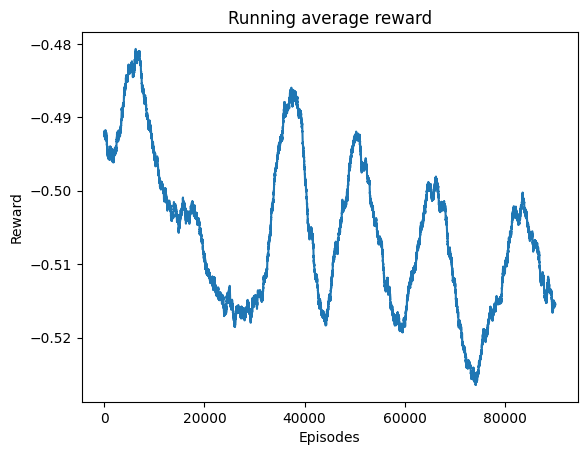

In [8]:
eps = 0.1
decay = 1
gamma = 0.9
freq_target_update = 100
batch_size = 32
hidden_dim = 64
depth = 1
buffer_capacity = 100_000
lr = 1e-3
weight_decay = 1e-4
n_episodes = 100_000

rewards, agent = train_embedding(n_episodes, eps, decay, gamma, freq_target_update, batch_size, hidden_dim, depth, buffer_capacity, lr, weight_decay)
plot_training_rewards(rewards)

In [9]:
env = Blackjack(seed=666)
rewards = [play_episode(env, agent) for i in range(n_test_episodes)]
rewards = np.array(rewards)
n_wins = np.sum(rewards == 1)
n_draws = np.sum(rewards == 0)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

Win rate: 0.0246
Draw rate: 0.0039


In [10]:
from src.utils.general import state_to_tensor_sequence

def main_sequence(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    rewards = np.zeros(n_episodes)
    for k in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_tensor_sequence(state, env.observation_space, env.max_number_of_cards)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_tensor_sequence(next_state, env.observation_space, env.max_number_of_cards)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)
        rewards[k] = reward.item()

    print(f"Training took {time.time() - start:.2f} seconds")
    return rewards

def train_sequence(n_episodes, eps, decay, gamma, freq_target_update, batch_size, hidden_dim, depth, buffer_capacity, lr, weight_decay):
    env = Blackjack(seed=42)

    exploration = EpsilonGreedy(epsilon=eps, decay=decay, seed=42)
    dqn_parameters = DQNParameters(batch_size=batch_size, gamma=gamma, freq_target_update=freq_target_update, device=device)

    network = MLP(input_dim=1 + env.max_number_of_cards, output_dim=env.action_space.n, hidden_dim=hidden_dim, depth=depth)
    target_network = MLP(input_dim=1 + env.max_number_of_cards, output_dim=env.action_space.n, hidden_dim=hidden_dim, depth=depth)
    target_network.load_state_dict(network.state_dict())

    network = network.to(device)
    target_network = target_network.to(device)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(network.parameters(), lr=lr, weight_decay=weight_decay)
    buffer = ReplayBuffer(capacity=buffer_capacity)

    agent = DQN(q_network=network, target_network=target_network, params=dqn_parameters, exploration=exploration, criterion=criterion, optimizer=optimizer, replay_buffer=buffer)

    rewards = main_sequence(env, agent, n_episodes)
    return rewards, agent

def play_episode(env, agent):
    state = env.reset()
    state = state_to_tensor_sequence(state, env.observation_space, env.max_number_of_cards)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        next_state = state_to_tensor_sequence(next_state, env.observation_space, env.max_number_of_cards)
        state = next_state
    return reward

100%|██████████| 100000/100000 [01:59<00:00, 838.39it/s]


Training took 119.28 seconds


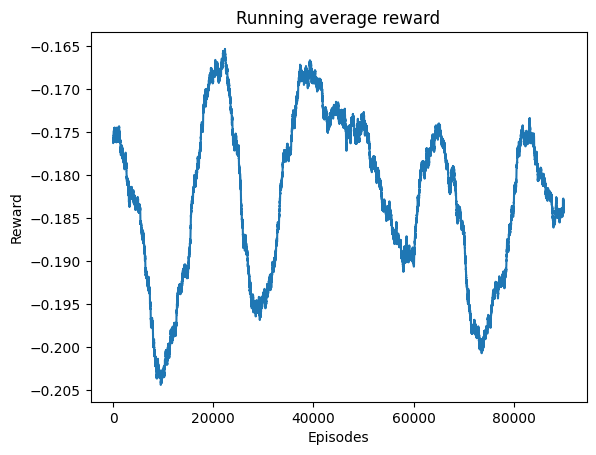

In [11]:
eps = 0.1
decay = 1
gamma = 0.9
freq_target_update = 100
batch_size = 32
hidden_dim = 64
depth = 1
buffer_capacity = 100_000
lr = 1e-3
weight_decay = 1e-4
n_episodes = 100_000

rewards, agent = train_sequence(n_episodes, eps, decay, gamma, freq_target_update, batch_size, hidden_dim, depth, buffer_capacity, lr, weight_decay)
plot_training_rewards(rewards)

In [12]:
env = Blackjack(seed=666)
rewards = [play_episode(env, agent) for i in range(n_test_episodes)]
rewards = np.array(rewards)
n_wins = np.sum(rewards == 1)
n_draws = np.sum(rewards == 0)
print(f"Win rate: {n_wins / n_test_episodes:.4f}")
print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

Win rate: 0.4100
Draw rate: 0.0781
